# 2021/12/12/compaired_by_kernelsize

In [9]:
ROI_ANNOTATION_CSV_PATH = "data/origin_data/anno_origin/new_roi.csv"
ANNOTATED_IMAGE_DIR_PATH = "data/ikeuchi_anno_data/sample_annotated_images"

## アノテーションされたBBoX RoI情報と対象画像情報の取得

In [10]:
import csv

images_dic = {}
with open(ROI_ANNOTATION_CSV_PATH) as csvfile:
    annotation_data_list = list(csv.reader(csvfile, delimiter=" ", quotechar="|"))
    for ann_data_icol in annotation_data_list:
        annotaion_info_str_list = ann_data_icol[0].split(",")
        if len(annotaion_info_str_list) == 4:
            image_name = annotaion_info_str_list[0]
            hmin, hmax = int(annotaion_info_str_list[1]), int(annotaion_info_str_list[2])
            image_path_annotated = annotaion_info_str_list[3]
            images_dic[image_name] = hmin, hmax, image_path_annotated

In [11]:
for image_name, ann_roi_data in images_dic.items():
    print(f"image_name: {image_name}, ann_roi_data: {ann_roi_data}")

image_name: 1632321916446.jpg, ann_roi_data: (200, 3000, 'data/ikeuchi_anno_data/1632321916446_anno.jpg')
image_name: 1632321916470.jpg, ann_roi_data: (200, 2300, 'data/ikeuchi_anno_data/1632321916470_anno.jpg')
image_name: 20211005_132152.jpg, ann_roi_data: (0, 2500, 'data/ikeuchi_anno_data/20211005_132152_anno.jpg')
image_name: 20211116_151459.jpg, ann_roi_data: (160, 2380, 'data/ikeuchi_anno_data/20211116_151459_anno.jpg')
image_name: 20211116_151936.jpg, ann_roi_data: (100, 2200, 'data/ikeuchi_anno_data/20211116_151936_anno.jpg')
image_name: 20211116_153631.jpg, ann_roi_data: (200, 2350, 'data/ikeuchi_anno_data/20211116_153631_anno.jpg')
image_name: 20211007_111644.jpg, ann_roi_data: (0, 2409, 'data/ikeuchi_anno_data/20211007_111644_anno.jpg')
image_name: 20211007_111818.jpg, ann_roi_data: (335, 2150, 'data/ikeuchi_anno_data/20211007_111818_anno.jpg')
image_name: 20211012_104927.jpg, ann_roi_data: (0, 2500, 'data/ikeuchi_anno_data/20211012_104927_anno.jpg')
image_name: 20211012_105

## Load image pathes

In [12]:
from pathlib import Path

annotated_dir_image_pathlib = Path(ANNOTATED_IMAGE_DIR_PATH)
input_image_dir_path = Path("data/ikeuchi_anno_data/sample_images")

tuple_list_valid_data_path_to_ann_data = []
for image_name, ann_data in images_dic.items():
    image_path = input_image_dir_path / image_name
    annotated_image_path = annotated_dir_image_pathlib / (Path(image_name).stem + "_anno.jpg")
    if image_path.exists() and annotated_image_path.exists():
        tuple_list_valid_data_path_to_ann_data.append((str(image_path), ann_data))
    else:
        print(f"image_path or annotated_image_path does not exist: {image_path}, {annotated_image_path}")


image_path or annotated_image_path does not exist: data/ikeuchi_anno_data/sample_images/20211012_105322.jpg, data/ikeuchi_anno_data/sample_annotated_images/20211012_105322_anno.jpg


In [13]:
import cv2
import numpy as np
from scripts.leaf_density_index import (
    rgb2lch,
    extract_bright_area,
    extract_green_area,
    normalize,
    discretize,
)
from scripts.utils import alpha_blend


def crop(image, hmin, hmax):
    return image[hmin:hmax, :, :]


def create_mask(image_path):
    leaf_image_bgr = cv2.imread(image_path)
    leaf_image_rgb = cv2.cvtColor(leaf_image_bgr, cv2.COLOR_BGR2RGB)
    leaf_image_lch = rgb2lch(leaf_image_rgb)

    bright_area_mask = extract_bright_area(leaf_image_lch)
    green_area_mask = extract_green_area(leaf_image_bgr)

    leaf_area_mask = 255 - (bright_area_mask & np.bitwise_not(green_area_mask))
    return leaf_image_rgb, leaf_area_mask


def create_images_by_kernelsize(leaf_image_rgb, leaf_area_mask_crop, kernel_size, hmin, hmax, density_min: int = 80):
    # Visualization (heatmap)
    density_img = normalize(cv2.blur(leaf_area_mask_crop, (kernel_size, kernel_size)), v_min=density_min)
    heatmap_img = cv2.applyColorMap(density_img, cv2.COLORMAP_JET)
    overlay_heatmap = alpha_blend(leaf_image_rgb, heatmap_img, hmin, hmax)
    overlay_heatmap = cv2.cvtColor(overlay_heatmap, cv2.COLOR_BGR2RGB)

    # Visualization (contour)
    contour_img = cv2.applyColorMap(discretize(density_img), cv2.COLORMAP_JET)
    overlay_contour = alpha_blend(leaf_image_rgb, contour_img, hmin, hmax)
    overlay_contour = cv2.cvtColor(overlay_contour, cv2.COLOR_BGR2RGB)

    return overlay_contour, overlay_heatmap

In [14]:
from functools import partial
from matplotlib import pyplot as plt
from scripts.utils import as_3ch_grayscale_with_roi


def visualize_images(image_path, ann_image_path, images_dic, kernel_size_list, resize_rate_to_visualize: float = 0.5):
    image_name = Path(image_path).name
    hmin, hmax, _ = images_dic[image_name]

    # call_annoimage
    anno_image = cv2.imread(ann_image_path)
    anno_image = cv2.cvtColor(anno_image, cv2.COLOR_BGR2RGB)
    leaf_image_rgb, leaf_area_mask = create_mask(str(image_path))
    leaf_area_mask_crop = leaf_area_mask[hmin:hmax]

    # binalization_image
    lch_mask_bgr = as_3ch_grayscale_with_roi(leaf_area_mask, leaf_image_rgb.shape, hmin, hmax)

    # crate_images_by_kernelsize
    images_bykernel_list = []
    for kernel_size in kernel_size_list:
        overlay_contour, overlay_heatmap = create_images_by_kernelsize(
            leaf_image_rgb, leaf_area_mask_crop, kernel_size, hmin, hmax
        )
        images_bykernel_list.append((overlay_contour, overlay_heatmap))

    # visualization
    fig, axes = plt.subplots(2, len(kernel_size_list) + 3, figsize=(24, 8))
    fig.suptitle(f"image_name : {image_name}", fontsize=16)

    # 0,1,2番目にそれぞれ、元画像、lch_mask、anno_imageを表示
    resize = partial(cv2.resize, dsize=None, fx=resize_rate_to_visualize, fy=resize_rate_to_visualize)
    leaf_image_rgb_resized = resize(leaf_image_rgb)
    lch_mask_bgr_resized = resize(lch_mask_bgr)
    leaf_image_rgb_resized = resize(leaf_image_rgb)
    anno_image_resized = resize(anno_image)

    axes[0][0].imshow(leaf_image_rgb_resized)
    axes[1][0].imshow(leaf_image_rgb_resized)
    axes[0][1].imshow(lch_mask_bgr_resized)
    axes[1][1].imshow(lch_mask_bgr_resized)
    axes[0][0].imshow(leaf_image_rgb_resized)
    axes[1][0].imshow(leaf_image_rgb_resized)
    axes[1][0].imshow(leaf_image_rgb_resized)
    axes[1][0].imshow(leaf_image_rgb_resized)
    axes[1][0].imshow(leaf_image_rgb_resized)
    axes[0][2].imshow(anno_image_resized)
    axes[1][2].imshow(anno_image_resized)
    for i in range(len(kernel_size_list)):
        axes[0][i + 3].set_title(f"k_size = {kernel_size_list[i]}", fontsize=10)
        axes[0][i + 3].imshow(resize(images_bykernel_list[i][0]))
        axes[1][i + 3].imshow(resize(images_bykernel_list[i][1]))
    for ax in axes.flatten():
        ax.tick_params(labelsize=6)
    plt.show()

## Visualize images

In [15]:
kernel_size_list = [100, 150, 200, 250, 300, 350, 400, 450]

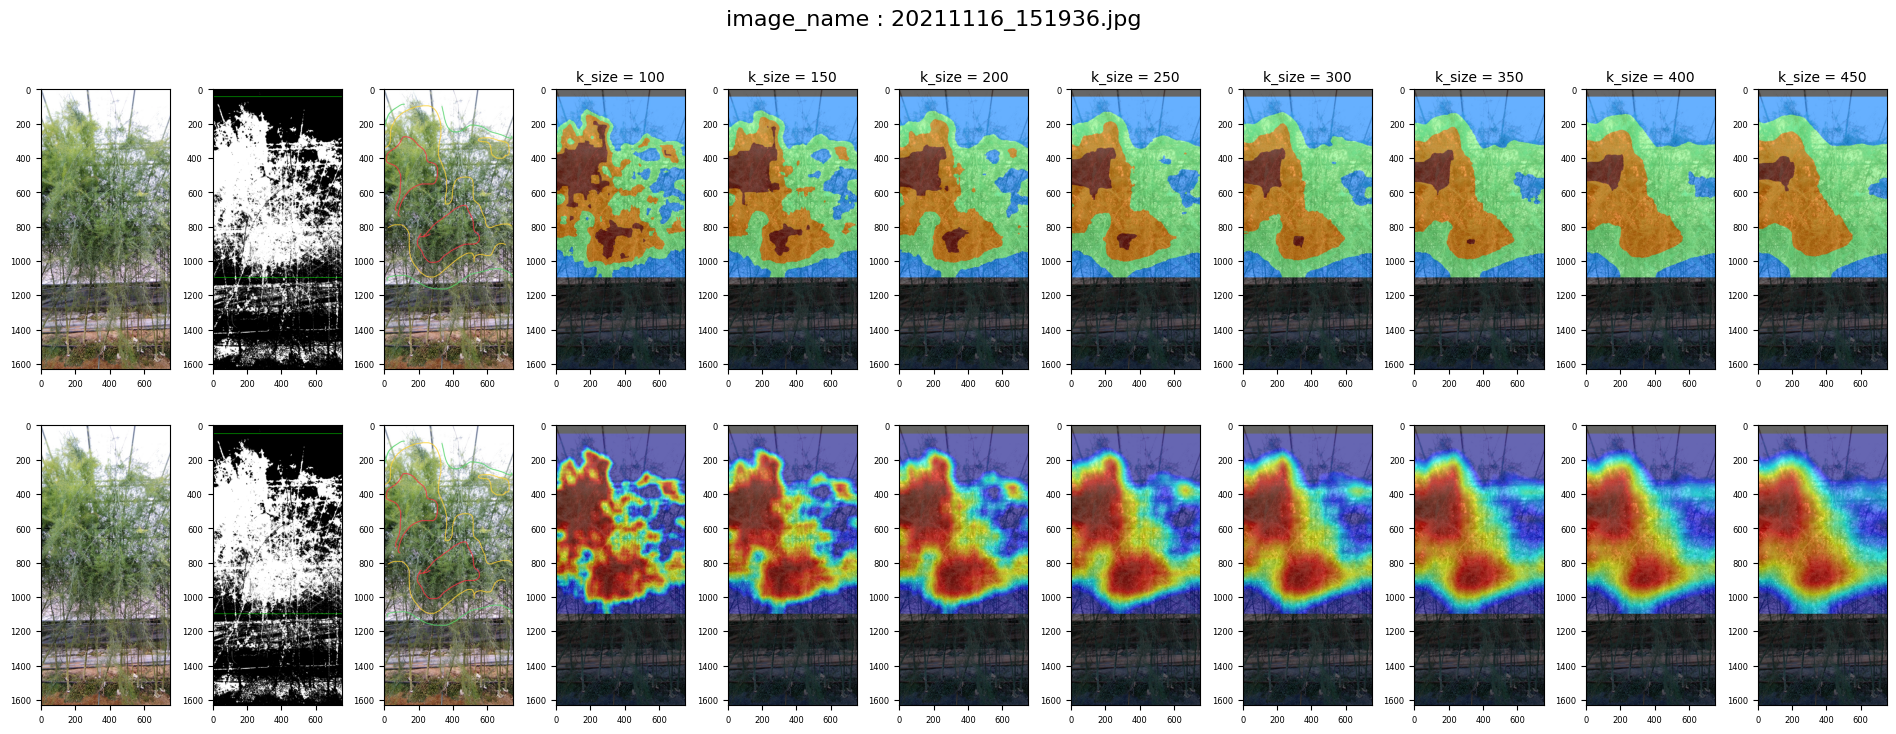

In [16]:
image_path, ann_data = tuple_list_valid_data_path_to_ann_data[4]
ann_image_path = str(annotated_dir_image_pathlib / (Path(image_path).stem + "_anno.jpg"))
visualize_images(image_path, ann_image_path, images_dic, kernel_size_list)